In [1]:
import sys
import os
import xml.etree.ElementTree
import csv
import re
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

# Openstreetmap Project

The goal of this project is to parse data from a openstreetmap OSM file (XML format), populate a database and perform some analysis.

## List of modules used

In [2]:
print("Python: Version %s"%(sys.version))
print("xml.etree.ElementTree: xml is a python embedded module. Please refer to the python's version.")
print("csv: Version %s"%(csv.__version__))
print("re: Version %s"%(re.__version__))
#print("sqlite3: Version %s"%(sqlite3.__version__))
print("pandas: Version %s"%(pd.__version__))


Python: Version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
xml.etree.ElementTree: xml is a python embedded module. Please refer to the python's version.
csv: Version 1.0
re: Version 2.2.1
pandas: Version 0.23.4


## Set the data file

In [3]:
#dataFileName = 'example.osm'
#dataFileName = 'daensen.osm'
#dataFileName = 'Hamburg_sued.osm'
#dataFileName = 'Buxtehude.osm'
dataFileName = 'Paris.osm'

In [4]:
statinfo = os.stat(dataFileName)
print('Size of the source file {}: {:.3f}Mb'.format(dataFileName, statinfo.st_size / (1024 * 1024))) 

Size of the source file Paris.osm: 505.828Mb


# Read data from OSM file and create some csv files

In [5]:
# List of all csv files
csvFiles = {'node':'nodes.csv',
         'way':'ways.csv',
         'node_tags': 'nodes_tags.csv',
         'way_tags': 'ways_tags.csv',
         'way_node':'ways_nodes.csv'}

# List of all fields for the csv files
fields = {'node': ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp'],
           'way': ['id', 'user', 'uid', 'version', 'changeset', 'timestamp'],
           'node_tags': ['id', 'key', 'value', 'type'],
           'way_tags': ['id', 'key', 'value', 'type'],
           'way_node': ['id', 'node_id', 'position']} 

def initCSVfiles():
    '''
    Create empty csv files and add the header line
    
    parameters:
    ------------
    None
    
    returns:
    --------
    a dictionary containing the file descriptor and the csv writer object
    '''
    fileDescriptor = {}
    for f in csvFiles:
        #print('init {}'.format(files[f]))
        fileId = open(csvFiles[f], 'w', encoding='utf-8')
        csvWriter = csv.writer(fileId, delimiter=';',
                            quotechar='\'', quoting=csv.QUOTE_MINIMAL)
        csvWriter.writerow(fields[f])
        fileDescriptor[f] = {}
        fileDescriptor[f]['fileId'] = fileId
        fileDescriptor[f]['csvWriter'] = csvWriter
        
    return fileDescriptor

def closeCSVfiles(fileDesc):
    '''
    Close all csv files opened
    
    parameters:
    -----------
    the file descriptor dictionary returned by the initCSVfiles function.
    
    returns:
    --------
    None
    '''
    for f in fileDesc:
        fileDesc[f]['fileId'].close()

def writeElem(elemType, elem, fileDesc):
    '''
    write an element in the corresponding csv file
    
    parameters:
    -----------
    - elemType: a string of the type of element to be written.
    - elem: dict of data to be written in the csv file
    - fileDesc: dictionary of the file decriptor (given by the initCSVfiles function)
    '''
    record = []
    for i in fields[elemType]:
        record.append(elem[i])
    
    fileDesc[elemType]['csvWriter'].writerow(record)

def parseTag(id, attrib):
    '''
    Parse the tag k and return the value, the key and the type
    
    parameters:
    -----------
    - id: id of the node or the way
    - attrib: XML object
    
    returns:
    --------
    a dictionary with the Id of the parent, the key, value and type
    '''
    
    if 'k' in attrib:
        pattern = re.compile('^([a-z_]+):(.*)$')
        match = pattern.match(attrib['k'])
    
        if match:
            type_ = match.group(1)
            key = match.group(2)
        else:
            type_ = attrib['k']
            key = ''
    else:
        key = None
        type_ = None
    
    # Replace semi-colon by a space in the value string to avoid issues by reading the csv file.
    value = attrib['v'].replace(';', ' ')
    #PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
    #if re.match(PROBLEMCHARS, value):
    #    print('Problem discovered: {}'.format(value))
    #    value = ''
    return {'id': id, 'key':key, 'value':value, 'type':type_}
    
def parseElement(element, fileDesc):
    '''
    parse an element and write the data in the different csv files
    
    parameters:
    -----------
    - element: XML object to be parsed
    - fileDesc: dictionary of the file decriptor (given by the initCSVfiles function)

    returns:
    --------
    None
    '''
    targetElement = ['node', 'way']
    
    if element.tag in targetElement:
        #print('Parsing: {}'.format(element.tag))
        selectedAttribs = fields[element.tag]

        # Parse the main elements Node and Way
        attribs = element.attrib
        elem = {}
        for i in selectedAttribs:
            elem[i] = attribs[i]  
        writeElem(element.tag, elem, fileDesc)
        
        # Parse the subelements Tag and Nd
        position = 0
        for e in element:
            tag = {}
            node = {}
            if e.tag == 'nd':
                node = {'id': elem['id'], 'node_id': e.attrib['ref'], 'position': position}
                position += 1
                writeElem('way_node', node, fileDesc)
            elif e.tag == 'tag':
                tag = parseTag(elem['id'], e.attrib)
                writeElem(element.tag + '_tags', tag, fileDesc)
        
def parseOSMfile(fileName):
    '''
    main function to extract the data from an OSM file to CSV files
    
    parameters:
    -----------
    fileName: string of the path of the OSM file
    
    returns:
    --------
    None
    '''
    fileDesc = initCSVfiles()
    e = xml.etree.ElementTree.parse(fileName).getroot()
    for element in e:
        parseElement(element, fileDesc)
    closeCSVfiles(fileDesc)

Now we can generate the CSV files:

In [6]:
parseOSMfile(dataFileName)

We see all CSV files in the current directory:

In [50]:
fileList = os.listdir()

print('List of csv files.')
pattern = re.compile('.*\.csv$')
for f in fileList:
    if pattern.match(f):
        statinfo = os.stat(f)
        print('File {} ({:.1f}kb)'.format(f, statinfo.st_size / 1024))
    

List of csv files.
File nodes_tags.csv (53341.5kb)
File ways_nodes.csv (58088.5kb)
File nodes.csv (154406.5kb)
File node_tags.csv (5.2kb)
File way_tags.csv (10.5kb)
File ways.csv (13265.5kb)
File way_node.csv (18.7kb)
File ways_tags.csv (32620.0kb)


Those files can be used to populate the database

# Create the database

It is necessary to create the database only once. A variable can be use to avoid to create the tables everytime the notebook is executed.

In [51]:
# Set this variable to True to for the regeneration of the database
regenerateDatabase = True

Create the database with the schema contains in the file 'data_wrangling_schema.sql'

In [52]:
conn = sqlite3.connect('Openstreetmap.db')
c = conn.cursor()

In [53]:
with open('data_wrangling_schema.sql') as f: 
    text = f.read()
    c.executescript(text)
    conn.commit()
    print('Execute SQL statement: \n{}'.format(text))


Execute SQL statement: 
CREATE TABLE nodes (
    id INTEGER PRIMARY KEY NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
);

CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id)
);

CREATE TABLE ways (
    id INTEGER PRIMARY KEY NOT NULL,
    user TEXT,
    uid INTEGER,
    version TEXT,
    changeset INTEGER,
    timestamp TEXT
);

CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways(id)
);

CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways(id),
    FOREIGN KEY (node_id) REFERENCES nodes(id)
);



# Populate the database

In [54]:
def populateDatabase(dbConn):
    for f in csvFiles:
        print('Reading file {} for table {}'.format(csvFiles[f], csvFiles[f].split('.')[0]))
        df = pd.read_csv(csvFiles[f], sep=';', dtype={"id": np.int32})
        df.to_sql(csvFiles[f].split('.')[0], dbConn, if_exists='replace', index=False)

In [55]:
populateDatabase(conn)

Reading file nodes.csv for table nodes
Reading file ways.csv for table ways
Reading file nodes_tags.csv for table nodes_tags


ValueError: invalid literal for int() with base 10: "Toilettes à l''étage accessibles par ascenseur'"

Now the database is populated and can be use.

# Analyse the data

## How many nodes in th database?

In [13]:
c.execute('SELECT COUNT(id) FROM nodes')
print('There are {} nodes in the database'.format(c.fetchall()[0][0]))

There are 2012441 nodes in the database


## How many ways in the database?

In [14]:
c.execute('SELECT COUNT(id) FROM ways')
print('There are {} ways in the database'.format(c.fetchall()[0][0]))

There are 233673 ways in the database


## How many users are in the tables?

In [15]:
c.execute('SELECT COUNT(DISTINCT user) FROM ways')
print('There are {} different users in the ways table'.format(c.fetchall()[0][0]))

c.execute('SELECT COUNT(DISTINCT user) FROM nodes')
print('There are {} different users in the nodes table'.format(c.fetchall()[0][0]))

There are 1826 different users in the ways table
There are 3393 different users in the nodes table


## What about fire protection?

In [16]:
c.execute('SELECT count(type) \
          FROM nodes_tags \
          WHERE type == \'fire_hydrant\' AND nodes_tags.key = \'type\';')
print('There are {} fire hydrant in the database'.format(c.fetchall()[0][0]))

There are 2256 fire hydrant in the database


We can extract their position.

In [17]:
c.execute('SELECT nodes.lat, nodes.lon, nodes_tags.type, nodes_tags.key, nodes_tags.value \
          FROM nodes \
          JOIN nodes_tags ON nodes.id = nodes_tags.id \
          WHERE nodes_tags.type == \'fire_hydrant\' AND nodes_tags.key = \'type\';')
res = c.fetchall()
res

[(48.8959708, 2.2699167, 'fire_hydrant', 'type', 'pillar'),
 (48.8327214, 2.2760964, 'fire_hydrant', 'type', 'pillar'),
 (48.8238475, 2.2972982999999996, 'fire_hydrant', 'type', 'pillar'),
 (48.8603916, 2.3509546, 'fire_hydrant', 'type', 'pillar'),
 (48.8232583, 2.3008135, 'fire_hydrant', 'type', 'pillar'),
 (48.8240106, 2.3028877, 'fire_hydrant', 'type', 'pillar'),
 (48.824318100000006, 2.3037415, 'fire_hydrant', 'type', 'pillar'),
 (48.8968959, 2.3816601000000004, 'fire_hydrant', 'type', 'pillar'),
 (48.897104399999996, 2.3816782, 'fire_hydrant', 'type', 'pillar'),
 (48.8944359, 2.3921105, 'fire_hydrant', 'type', 'pillar'),
 (48.8963293, 2.3809167, 'fire_hydrant', 'type', 'pillar'),
 (48.8964706, 2.3824606, 'fire_hydrant', 'type', 'pillar'),
 (48.8804201, 2.3556044999999997, 'fire_hydrant', 'type', 'pond'),
 (48.8805078, 2.3551757999999996, 'fire_hydrant', 'type', 'pond'),
 (48.8420645, 2.3669152, 'fire_hydrant', 'type', 'pillar'),
 (48.879971000000005, 2.2507618, 'fire_hydrant', 'ty

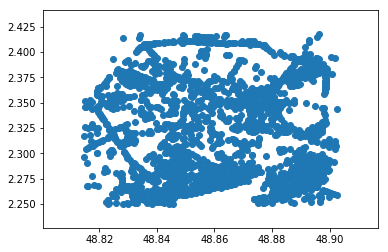

In [18]:
lat = []
lon = []
for i in res:
    lat.append(i[0])
    lon.append(i[1])
    
plt.scatter(lat, lon)
plt.show()

## Check of the name of the objects

In [19]:
c.execute('SELECT DISTINCT value FROM ways_tags WHERE type == \'name\'')
c.fetchall()

[('Rue Nationale',),
 ('Avenue des Gobelins',),
 ('Place des Alpes',),
 ('Rue Taine',),
 ("'Rue Saint-Louis en l''Île'",),
 ('Quai de Bourbon',),
 ('Rue Jean du Bellay',),
 ('Quai de Béthune',),
 ('Pont Saint-Louis',),
 ('Pont Louis-Philippe',),
 ('Rue Boutarel',),
 ('Rue Budé',),
 ('Rue des Deux Ponts',),
 ('Pont de la Tournelle',),
 ('Pont Marie',),
 ('Rue Poulletier',),
 ('Rue de Bretonvilliers',),
 ('Pont de Sully',),
 ('Boulevard Henri IV',),
 ('Rue Fagon',),
 ('Place Nationale',),
 ('Rue du Château des Rentiers',),
 ('Rue Monge',),
 ('Rue des Fossés Saint-Bernard',),
 ("'Rue d''Arras'",),
 ('Place de la République',),
 ('Platz der Republik',),
 ('Place de la Bastille',),
 ('Rue de Lyon',),
 ('Rue de Charenton',),
 ('Avenue du Général Michel Bizot',),
 ('Boulevard Diderot',),
 ('Rue du Faubourg Saint-Antoine',),
 ('Avenue du Docteur Arnold Netter',),
 ('Rue Alphonse Karr',),
 ('Avenue de la Porte de la Villette',),
 ('Rue Gaston Tessier',),
 ('Avenue des Champs-Élysées',),
 ('Camp

# Close the database

In [20]:
conn.close()